# 04 -- Build NLP Models

This code was run on the AWS instance.  

PREREQUISITES:  This notebook requires the following items to run:   

   1) Functional MongoDB collection containing the journal abstracts, created by 02_HTML_to_mongo.ipynb.  (I used the Mongo dump and restore features to move the DB from my laptop to the AWS instance).   
   
   2) Pickled dictionary of reddit/r/askscience comments, created by 03_AWS_Parse_and_pickle_reddit_comments.ipynb.  

______________________

This notebook builds the NLP trasnforms and models needed for expertise identification.  These objects are saved as pickles for use by the expertise identification flask app.  The steps used here are as follows:

1) The 

### Imports

In [41]:
import pandas as pd
from pprint import PrettyPrinter
import pymongo
import string
import numpy as np
import os
from collections import defaultdict, Counter
import pickle
import time
import sys
from copy import deepcopy
import sklearn
import seaborn as sns
from sklearn import metrics, pipeline, preprocessing, cross_validation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import __version__
%matplotlib inline

### Functions to map / filter abstracts based on journal topics 

In [42]:
# Build a dictionary mapping E_ISSN (journal ID codes) to topics.  
# This is done by reading the Scopus journal list.

def build_journal_topics_dict (fp_jlist):
    df_j = pd.read_csv (fp_jlist, sep = '\t')

    # Build a default dict.  The keys will be journal E_ISSN codes.
    # The values will be DICTIONARIES, of the form:
    # {IS_INTERDISCIPLINARY:bool, IS_MULTITOPIC:bool, DETAILED_TOPICS:list, SIMPLE_TOPICS:list}

    j_topic_dict = defaultdict(dict)
    for row_idx in range (len(df_j)):
        j = df_j.ix[row_idx]  # Extract single row
        e_issn = j.E_ISSN
        is_interdisc = j.IS_INTERDISCIPLINARY
        is_multitopic = j.IS_MULTITOPIC
        try: 
            detail_topic_list = [i.strip() for i in j.ALL_CLASSIFICATION_TOPICS.split(';')]
        except: detail_topic_list = []
        try:
            simple_topic_list = [i.strip() for i in j.ALL_SIMPLE_TOPICS.split(';')]
        except:
            simple_topic_list = []
        j_topic_dict [e_issn] = {'IS_INTERDISCIPLINARY':is_interdisc,\
                                 'IS_MULTITOPIC':is_multitopic,\
                                 'DETAILED_TOPICS':detail_topic_list,\
                                 'SIMPLE_TOPICS':simple_topic_list}
    return j_topic_dict

###############################################

# Get topic lables for a list of docs

def get_doc_labels (doc_list, j_topic_dict):
    interdisc = [j_topic_dict[i['E_ISSN']]['IS_INTERDISCIPLINARY'] for i in doc_list]
    multitopic = [j_topic_dict[i['E_ISSN']]['IS_MULTITOPIC'] for i in doc_list]
    topics = [j_topic_dict[i['E_ISSN']]['SIMPLE_TOPICS'] for i in doc_list]
    return interdisc, multitopic, topics
    
###############################################

# Remove documents coming from journals on given topic

# Given a list of documents and corresponding list of topics, remove those of a given topic
def filter_by_topic (doc_list, j_topic_dict, bad_topic):
    r = doc_list
    for t in bad_topic:
        r = filter (lambda x: not (t in j_topic_dict[x['E_ISSN']]['SIMPLE_TOPICS']), r)
    return r

### FUNCTION:  Read db random subset, for test / debug

In [43]:
# q_dict is optional dictionary filtering the find.  Will find
# everything if empty.  n is number of items to return.

def read_random_db_subset (col, n, q_dict = {}):
    id_list = col.distinct ('_id') # Gets list of unique values for key.  Should equal total
                                   # number of docs in the collection since _id is unique.
    n = min (n, len(id_list)) # Limit subset size to size of the whole collection.
    id_subset = np.random.choice (id_list, size = n, replace = False) # replace False --> no duplicates in
                                                                      # random set.
    r = [] # List of queries to return
    for id_val in id_subset:
        curs = col.find ({'_id':id_val})
        r.append (curs.next())
    return r


### FUNCTION:  Compute sample weights to simulate oversampling (this is to account for unbalanced topic labels)

In [44]:
# Given the list of topics, this function returns corresponding list of weights, which are inversely 
# proportional to the frequency of the topic.  Most common topic has weight = 1, a topic
# half as common as the most-common is weight 2, etc.

def calc_sample_weights (topic_list):
    n = len (topic_list)
    topic_count = Counter (topic_list)
    r = [1.0/(topic_count[i]) for i in topic_list]
    norm = sum(r)
    r = np.array ([float (i) / norm  for i in r])
    return r

### FUNCTION:  Plot and pickle normalized confusion matrix to test field-of-study classifiers

In [53]:
# Given predicted and 'correct' field-of-study labels,
# plot a confusion matrix.

def plot_confusion_matrix (Y_test, Y_pred, labels, fp_conf_mat):
    
    # Rows --> Truth
    # Columns --> Prediction
    conf_matrix  = metrics.confusion_matrix(Y_test, Y_pred)
    conf_matrix = normalize (conf_matrix, norm = 'l1', axis = 1)
    sns.heatmap (conf_matrix, annot=False, linewidths=0.5, cmap ='Spectral', \
                 xticklabels = labels, yticklabels = labels )
    acc = accuracy_score (Y_test, Y_pred)
    print 'TOTAL ACCURACY = ' + str (acc)
    with open (fp_conf_mat,'w') as f:
        pickle.dump (conf_matrix, f)
    return conf_matrix

### FUNCTION: Count number of abstracts for each journal topic

In [46]:
def print_n_abs_per_topic (topic_list):
    print 'TOTAL ABSTRACTS = ' + str(len(topic_list))
    print
    print '# Abstracts per topic...'
    PrettyPrinter(width=1).pprint (dict(Counter(topic_list)))
        

# MAIN  4a)
### Run TFIDF vectorizer and truncated SVD on abstracts.  Pickle the transformer obejcts and transformed abstract corpus

In [47]:
# Journal list -- contains topic info
fp_jlist = '~/proj_asksci/files_out/filtered_journal_list.txt'

# Path for pickle files -- create if needed
bp_pickles = '/home/ubuntu/proj_asksci/files_out/pickles'
if not os.path.exists (bp_pickles): os.makedirs (bp_pickles)

db_name = 'mongo_dump'  # MongoDB name

fn_ab_pkl = 'ab_list.pkl'        #filename for abstract pickle
fn_topic_pkl = 'topic_list.pkl'  # filename for topic pickle
fn_tfidf_obj = 'tfidf_obj.pkl'   # filename for TFIDF vectorizer pickle
fn_ab_vec = 'ab_list_vec.pkl'    # filename for vectorized abstract pickle
fn_SVD_obj = 'TruncSVD_200_comp.pkl' # filename for Truncated SVD transformer object
fn_ab_SVD  = 'ab_list_SVD.pkl'   # filename for vectorized, SVD-transformed abstract corpus
fn_ab_SVC  = 'SVC_SVD_200.pkl'   # filename for pickled SVC, trained on truncated SVD-transformed corpus
n_dim = 200 # Number of components to retain for truncated SVD


# Remove abstracts from journals with the following topics.  Justifications:
# Arts / humanities not covered in askscience.  Social sciences in principle should be included
# but individual fields are not well repreented (econ and physch are included in separate topics)
# Decision sciences has very few items, and overlaps consideraby with computer science.  
# Finally, 'Energy' is very hard to distinnguish from either environment sciences or engineering.
remove_topic_list = ['DECISION_SCIENCES_ALL','ARTS_AND_HUMANITIES_ALL', 'SOCIAL_SCIENCES_ALL', \
                     'ENERGY_ALL', 'INTERDISCIPLINARY_ALL', 'MULTIDISCIPLINARY']

# First we build a dictionary mapping journals (by E_ISSN) to topics
j_topic_dict = build_journal_topics_dict (fp_jlist)

# Access the mongodb collection (just one collection in the db)
client = pymongo.MongoClient()
db = client.get_database(db_name)
col = db.get_collection (db.collection_names()[0]) 

# Just get all the doc in the db, and then shuffle them.
print 'Reading whole abstract db...'
curs = col.find({})
doc_list = []
for i in range (curs.count()):
    doc_list.append(curs.next())
print 'Shuffling abstrast set'
np.random.shuffle(doc_list) # Randomly shuffle the list of documents

# Filter list to exclude unwanted topics
print 'Filtering topics'
doc_list = filter_by_topic (doc_list, j_topic_dict, remove_topic_list)

# Get labels topic labels for the docs.
interdisc, multitopic, topic_list = get_doc_labels (doc_list, j_topic_dict)

# Each item in topic_list is a one-element list.  Extract items to make simple list.
topic_list = [i[0] for i in topic_list]

###################################################

# Pickle the abstracts (13.5 sec on AWS)
print 'Pickling the abstracts'
X = [i['ABSTRACT'] for i in doc_list]
fp_ab_list = os.path.join (bp_pickles, fn_ab_pkl)
with open (fp_ab_list,'w') as f:
    pickle.dump(X, f)

###################################################
    
# Pickle the topics list (1.4 sec on AWS)
print 'Pickling the topics'
fp_topic_list = os.path.join (bp_pickles, fn_topic_pkl )
with open (fp_topic_list, 'w') as f:
    pickle.dump (topic_list, f)
    



Reading whole abstract db...
Shuffling abstrast set
Filtering topics
Pickling the abstracts
Pickling the topics


In [48]:
####################################################

# Count how many abstracts are present for each topic.
print 'Counting # abstracts for each topic\n'
print_n_abs_per_topic (topic_list)

Counting # abstracts for each topic

TOTAL ABSTRACTS = 811496

# Abstracts per topic...
{'AGRICULTURAL_AND_BIOLOGICAL_SCIENCES_ALL': 59685,
 'BIOCHEMISTRY_GENETICS_AND_MOLECULAR_BIOLOGY_ALL': 184379,
 'BUSINESS_MANAGEMENT_AND_ACCOUNTING_ALL': 15136,
 'CHEMICAL_ENGINEERING_ALL': 7228,
 'CHEMISTRY_ALL': 42887,
 'COMPUTER_SCIENCE_ALL': 34468,
 'EARTH_AND_PLANETARY_SCIENCES_ALL': 57581,
 'ECONOMICS_ECONOMETRICS_AND_FINANCE_ALL': 14739,
 'ENGINEERING_ALL': 51789,
 'ENVIRONMENTAL_SCIENCE_ALL': 48730,
 'IMMUNOLOGY_AND_MICROBIOLOGY_ALL': 34199,
 'MATERIALS_SCIENCE_ALL': 29100,
 'MATHEMATICS_ALL': 52091,
 'NEUROSCIENCE_ALL': 56243,
 'PHYSICS_AND_ASTRONOMY_ALL': 79117,
 'PSYCHOLOGY_ALL': 44124}


In [49]:
# Create a TFIDF Vectorizer for the entire corpus.  Then pickle the vectorizer
# object and the vectorized abstact corpus
print 'Creating and fitting TFIDF vectorizer'
tfidf_obj = TfidfVectorizer(min_df = 4, max_df=0.5, \
                            ngram_range = (1,1), stop_words='english')
tfidf_obj.fit (X)

print 'Pickling vectorizer'
with open (os.path.join (bp_pickles, fn_tfidf_obj), 'w') as f:
    pickle.dump (tfidf_obj, f)

print 'Vectorizing abstract set'
X_vec = tfidf_obj.transform (X)

print 'Saving pickled abstracts'
with open (os.path.join (bp_pickles, fn_ab_vec), 'w') as f:
    pickle.dump (X_vec, f)
    
####################################################

# Now we will build a 200-dimension Truncated SVD transformer.  Train this on the vectorized
# abstract corpus.

print 'Building and fitting Truncated SVD object and SVD-transformin abstract corpus'
SVD_obj = TruncatedSVD (n_components = n_dim)
X_vec_SVD = SVD_obj.fit_transform (X_vec)

# Pickle the Trunc SVD transformer and the SVD-transformed corpus
print 'Pickling SVD transformer'
with open (os.path.join (bp_pickles, fn_SVD_obj),'w') as f:
    pickle.dump (SVD_obj, f)
    
# Pickle the SVD-transformed corpus
print 'Pickling SVD-transformed corpus'
with open (os.path.join (bp_pickles, fn_ab_SVD), 'w') as f:
    pickle.dump (X_vec_SVD, f)
    

####################################################
    
#weights = calc_sample_weights (topic_list)
#SVC_obj = LinearSVC (penalty='l2', loss='hinge')
#SVC_obj.fit (X_vec_SVD, topic_list, sample_weight = weights)
#with open (os.path.join (bp_pickles, fn_ab_SVC), 'w') as f:
#    pickle.dump (SVC_obj, f)

# Section below runs train / test splits on the SVC and Random Forest Classifiers.
    

Creating and fitting TFIDF vectorizer
Pickling vectorizer
Vectorizing abstract set
Saving pickled abstracts
Building and fitting Truncated SVD object and SVD-transformin abstract corpus
Pickling SVD transformer
Pickling SVD-transformed corpus


# MAIN 4b)
This section runs train / test splits on a Support Vector Classifier and Random Forest Classifier, with and without applying the 200-dimension SVD transformation.

In [51]:
topic_list = np.array (topic_list)
test_frac = 0.2 #Fraction to withhold for testing the classifiers
    
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split \
                               (X_vec, topic_list, test_size = test_frac)
weights = np.array (calc_sample_weights (Y_train))    
Y_train = np.array (Y_train)
Y_test  = np.array (Y_test)



### First, test the SVC classifier using the raw (no SVD) vectorized data

Support Vector Classifier (raw) train time....
CPU times: user 2min 1s, sys: 24 ms, total: 2min 1s
Wall time: 2min 1s
Support Vector Classifier (raw) predict time....
CPU times: user 280 ms, sys: 0 ns, total: 280 ms
Wall time: 278 ms
TOTAL ACCURACY = 0.833123844732


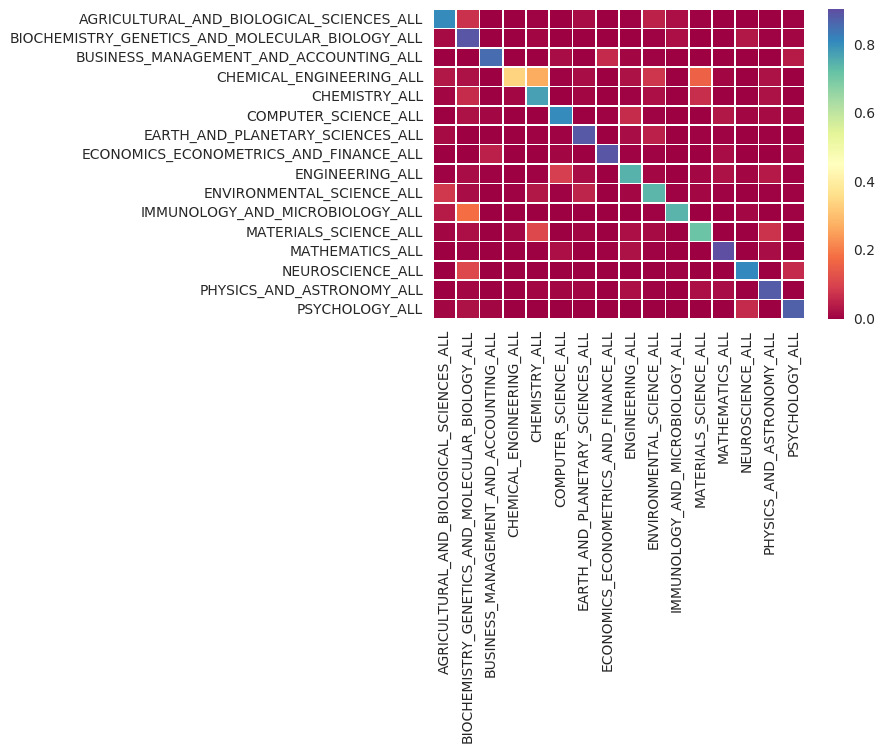

In [54]:
classifier = LinearSVC (penalty='l2', loss='hinge')
print 'Support Vector Classifier (raw) train time....'
%time classifier.fit (X_train, Y_train, sample_weight = weights)
print 'Support Vector Classifier (raw) predict time....'
Y_pred = %time classifier.predict (X_test)
fp_conf_mat = os.path.join (bp_pickles, 'conf_matrix_SVC_raw.pkl')
cm_svc_raw = plot_confusion_matrix (Y_test, Y_pred, sorted (np.unique(Y_test)),\
                                    fp_conf_mat)
del classifier #Delete the classifier to save memory



### Test the Support Vector Classifier in conjuction with 200-component Truncated SVD

SVD Transform time (80% Training set)...
CPU times: user 9.54 s, sys: 260 ms, total: 9.8 s
Wall time: 9.8 s
SVD Transform time (20% test set)...
CPU times: user 2.44 s, sys: 100 ms, total: 2.54 s
Wall time: 2.54 s
Support Vector Classifier Fit time (with SVD)...
CPU times: user 1min 15s, sys: 0 ns, total: 1min 15s
Wall time: 1min 15s
Support Vector Classifier Predict Time (with SVD)....
CPU times: user 248 ms, sys: 24 ms, total: 272 ms
Wall time: 53.1 ms
TOTAL ACCURACY = 0.749081947012


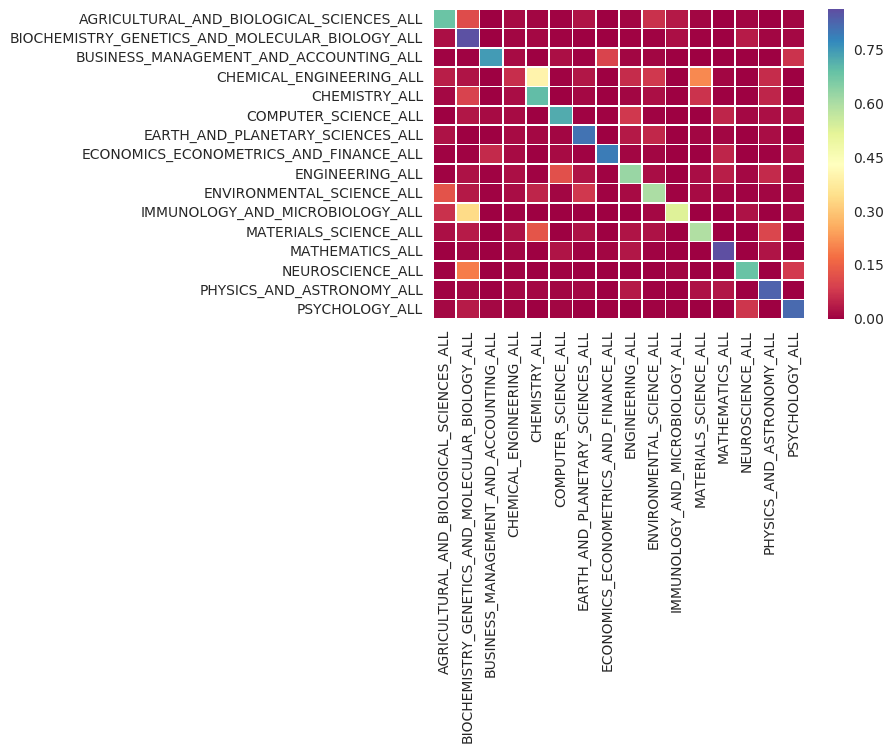

In [55]:
##### SVC, using SVD-transformed data

classifier = LinearSVC (penalty='l2', loss='hinge')  
print 'SVD Transform time (80% Training set)...'
X_train_SVD = %time SVD_obj.transform (X_train)
print 'SVD Transform time (20% test set)...'
X_test_SVD  = %time SVD_obj.transform (X_test)
print 'Support Vector Classifier Fit time (with SVD)...'
%time classifier.fit (X_train_SVD, Y_train, sample_weight = weights)
print 'Support Vector Classifier Predict Time (with SVD)....'
Y_pred = %time classifier.predict (X_test_SVD)
fp_conf_mat = os.path.join (bp_pickles, 'conf_matrix_SVC_SVD.pkl')
cm_svc_svd = plot_confusion_matrix (Y_test, Y_pred, sorted (np.unique(Y_test)),\
                                   fp_conf_mat)
del classifier #Delete the classifier to save memory


### Test a Random Forest Classifier with raw TFIDF-vectorized Data

RANDOM FOREST RAW FIT TIME....
CPU times: user 2h 15min 7s, sys: 6.32 s, total: 2h 15min 13s
Wall time: 11min 14s
RANDOM FOREST RAW PREDICT TIME...
CPU times: user 13.9 s, sys: 128 ms, total: 14 s
Wall time: 1.4 s
TOTAL ACCURACY = 0.70808995687


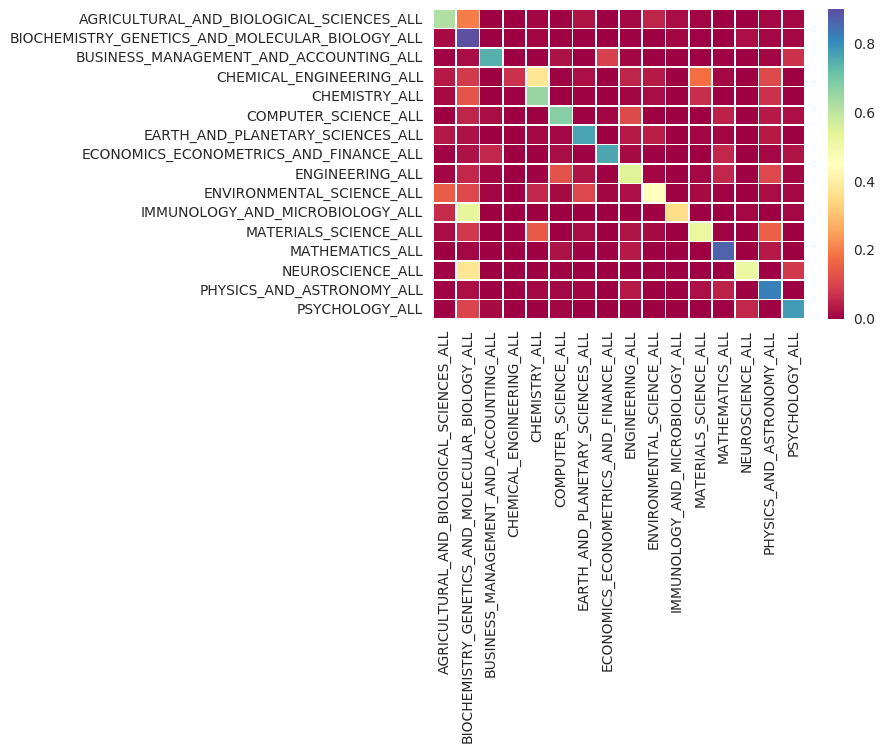

In [56]:
##### Random Forest, using raw vecorized (no SVD) data
classifier = RandomForestClassifier (n_estimators = 20, random_state=42, n_jobs = -1)
print 'RANDOM FOREST RAW FIT TIME....'
%time classifier.fit (X_train, Y_train, sample_weight = weights)
print 'RANDOM FOREST RAW PREDICT TIME...'
Y_pred = %time classifier.predict (X_test)
fp_conf_mat = os.path.join (bp_pickles, 'conf_matrix_forest_raw.pkl')
cm_forest_raw = plot_confusion_matrix (Y_test, Y_pred, sorted (np.unique(Y_test)),fp_conf_mat)
del classifier #Delete the classifier to save memory

### Test Random Forest Classifier with 200-component Truncated SVD

RANDOM FOREST w/SVD FIT TIME....
CPU times: user 9min 26s, sys: 448 ms, total: 9min 27s
Wall time: 51.4 s
RANDOM FOREST w/ SVD PREDICT TIME....
CPU times: user 3.49 s, sys: 80 ms, total: 3.57 s
Wall time: 573 ms
TOTAL ACCURACY = 0.726826863832


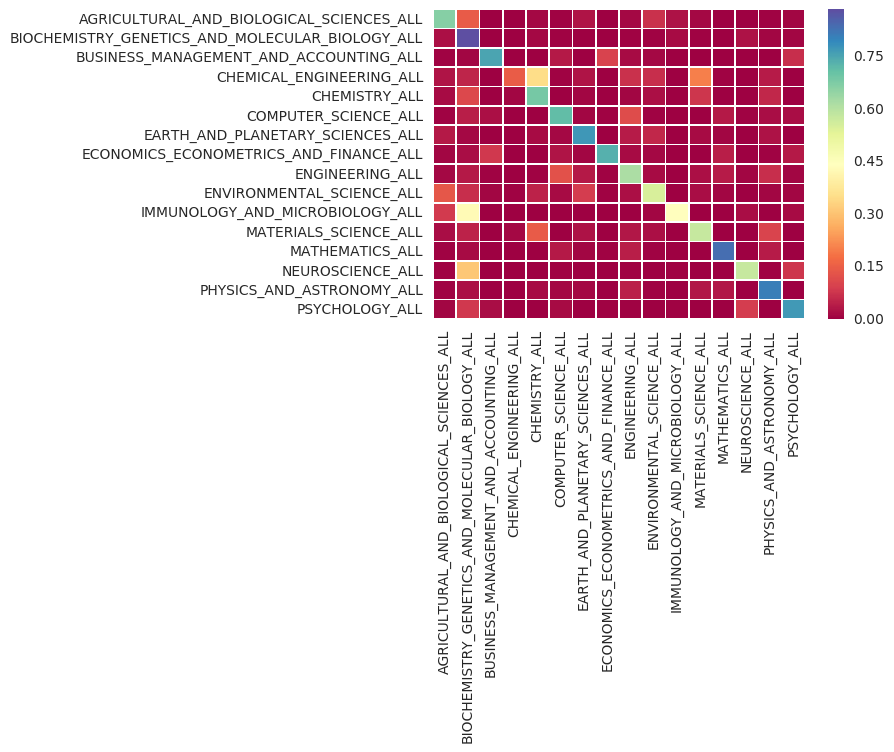

In [57]:
##### Random Forest, using SVD-transformed data
classifier = RandomForestClassifier (n_estimators = 20, random_state=42, n_jobs = -1)
print 'RANDOM FOREST w/SVD FIT TIME....'
%time classifier.fit (X_train_SVD, Y_train, sample_weight = weights)
print 'RANDOM FOREST w/ SVD PREDICT TIME....'
Y_pred = %time classifier.predict (X_test_SVD)
fp_conf_mat = os.path.join (bp_pickles, 'conf_matrix_forest_SVD.pkl')
cm_forest_svd = plot_confusion_matrix (Y_test, Y_pred, sorted (np.unique(Y_test)),fp_conf_mat)
del classifier #Delete the classifier to save memory


### The SVC, along with Truncated SVD, works reasonably well to match topic to the journal of origin.  Train an SVC on all the abstracts... the Flask app will use this classifier to assign a broad topic to the user question.
